# Noise assessment in ABC

In [17]:
from study_abc_noise.vars import ModelVars
import numpy as np
import pyabc
import ssa
import matplotlib.pyplot as plt
from collections import OrderedDict


class MRNATranscriptionModelVars(ModelVars):

    def __init__(self,
                 n_acc: int = 1000,
                 noise_success_probability: float = 0.70,
                 pdf_max: float = None,
                 n_t : int = 30,
                 t_max: int = 90):
        super().__init__(
            p_true = OrderedDict([('transcription', 10)]),
            n_acc = n_acc,
            pdf_max=pdf_max)
        self.limits = OrderedDict([('transcription', (0, 15))])
        self.reactants = np.array([[0], [1]])
        self.products = np.array([[1], [0]])
        self.n_t = n_t
        self.t_max = t_max
        self.output = ssa.output.ArrayOutput(
            np.linspace(0, self.t_max, self.n_t))
        self.x0 = np.array([0])
        self.noise_success_probability = noise_success_probability

    def get_id(self):
        return f"mrna_transcription_{self.n_t}_{self.t_max}_" \
               f"{self.noise_success_probability}"

    def get_prior(self):
        return pyabc.Distribution(
            **{key: pyabc.RV('uniform', bounds[0], bounds[1])
               for key, bounds in self.limits.items()})

    def get_distance(self):
        def l2(x, y):
            return np.sum(np.power( (x['mrna'] - y['mrna']), 2))
        return l2

    def get_kernel(self):
        kernel = pyabc.distance.BinomialKernel(
            p=self.noise_success_probability,
            keys=['mrna'],
            ret_scale=pyabc.distance.RET_SCALE_LOG,
            pdf_max=self.pdf_max)
        return kernel

    def get_model(self):
        def model(p):
            # anything (e.g. pd.DataSeries) -> OrderedDict
            p = OrderedDict([('transcription', p['transcription']),
                             ('decay', 0.2)])
            k = np.array(list(p.values()))  # order should be correct
            ssa_model = ssa.Model(
                reactants=self.reactants, products=self.products,
                t_max=self.t_max, x0=self.x0, k=k,
                output=self.output)
            result = ssa_model.simulate(n_reps=1)
            return {'t': result.list_ts[0],
                    'mrna': result.list_xs[0].flatten()}
        return model

    def get_model_noisy(self):
        def model_noisy(p):
            y = self.get_model()(p)
            successes = np.random.binomial(
                n=y['mrna'].flatten().astype(dtype=int),
                p=self.noise_success_probability)
            y['mrna'] = successes
            return y
        return model_noisy
    

"""
Illustrate the problem arising when not accounting for measurement noise.
Possible test cases: A deterministic model (-> ML estimator weighted by the
prior), and a simple SSA model (-> overestimation of parameters promoting
noise).

This means using a non-noisy model together with a deterministic acceptor,
and comparing that to the true analysis performed using either a noisy model,
or a stochastic acceptor.
"""

import pyabc
import sys
from study_abc_noise.util import create_sampler, get_timestamp
from study_abc_noise.vars import AnalysisVars, Task


mv = MRNATranscriptionModelVars(n_acc=100, n_t=10, noise_success_probability=0.7)
#mv.pdf_max = -155

# create analysis settings
list_analysis_vars = []
for acceptor, id_ in [
        (pyabc.StochasticAcceptor(
            temp_schemes=[
                pyabc.acceptor.scheme_acceptance_rate,
                pyabc.acceptor.scheme_exponential_decay],
            pdf_max_method=pyabc.acceptor.pdf_max_take_max_found
        ), "stochastic_acceptor_ada_c"),
        #(pyabc.StochasticAcceptor(
        #    temp_schemes=[
        #        pyabc.acceptor.scheme_acceptance_rate,
        #        pyabc.acceptor.scheme_exponential_decay],
        #), "stochastic_acceptor"),
        (pyabc.UniformAcceptor(), "deterministic"),
        (pyabc.UniformAcceptor(), "noisy_model"),]:
    list_analysis_vars.append(
        AnalysisVars(
            get_acceptor=lambda acceptor=acceptor: acceptor, min_acc_rate=1e-8, id_=id_))

# create tasks
tasks = []
for analysis_vars in list_analysis_vars:
    task = Task.from_vars(analysis_vars, mv, 0)
    task.n_pop = 10
    tasks.append(task)
# overwrite deterministic setting
tasks[1].model = mv.get_model()
tasks[1].eps_min = 0.0

# run
for task in tasks:
    task.execute()

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-28 23:30:38.384541, end_time=None)>
INFO:ABC:Calibration sample before t=0.


Result id:  mrna_transcription_10_90_0.7__stochastic_acceptor_ada_c__0__0
Skipping since exists already.
Result id:  mrna_transcription_10_90_0.7__deterministic__0__0


INFO:Epsilon:initial epsilon is 3713.9999999999936
INFO:ABC:t:0 eps:3713.9999999999936
INFO:ABC:Acceptance rate: 0.45662100456621.
INFO:ABC:t:1 eps:1548.9999999999998
INFO:ABC:Acceptance rate: 0.5405405405405406.
INFO:ABC:t:2 eps:843.8726730724944
INFO:ABC:Acceptance rate: 0.44642857142857145.
INFO:ABC:t:3 eps:513.7545198892494
INFO:ABC:Acceptance rate: 0.32894736842105265.
INFO:ABC:t:4 eps:414.6210235561326
INFO:ABC:Acceptance rate: 0.20161290322580644.
INFO:ABC:t:5 eps:339.30658059239187
INFO:ABC:Acceptance rate: 0.09940357852882704.
INFO:ABC:t:6 eps:289.96756064289406
INFO:ABC:Acceptance rate: 0.06680026720106881.
INFO:ABC:t:7 eps:250.48264848248922
Process Process-333:
Traceback (most recent call last):
  File "/home/yannik/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-334:
  File "/home/yannik/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (mo

KeyboardInterrupt: 

  File "<ipython-input-17-bfcb3c1602cc>", line 63, in model
    result = ssa_model.simulate(n_reps=1)
  File "/home/yannik/ssa/ssa/model.py", line 90, in simulate
    ret = self.engine.execute(tasks)
  File "/home/yannik/pyabc/pyabc/model.py", line 224, in accept
    sum_stats_calculator)
  File "/home/yannik/pyabc/pyabc/model.py", line 118, in summary_statistics
    raw_data = self.sample(pars)
  File "/home/yannik/ssa/ssa/model.py", line 90, in simulate
    ret = self.engine.execute(tasks)
  File "/home/yannik/ssa/ssa/engine.py", line 55, in execute
    ret.append(task.execute())
  File "/home/yannik/ssa/ssa/engine.py", line 55, in execute
    ret.append(task.execute())
  File "/home/yannik/pyabc/pyabc/model.py", line 267, in sample
    return self.sample_function(pars)
  File "/home/yannik/ssa/ssa/engine.py", line 24, in execute
    return self.alg(**self.alg_args)
  File "/home/yannik/ssa/ssa/direct.py", line 28, in direct
    hazards = k * (x ** reactants).prod(axis=1)
  File "/ho

Using db files ['db_mrna_transcription_10_90_0.7__stochastic_acceptor_ada_c__0__0.db', 'db_mrna_transcription_10_90_0.7__deterministic__0__0.db']


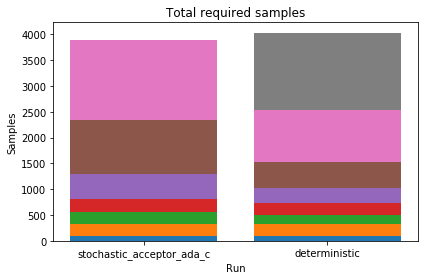

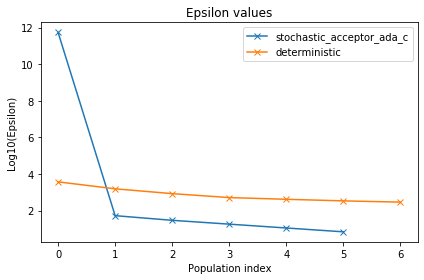

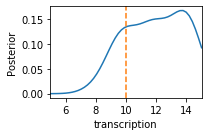

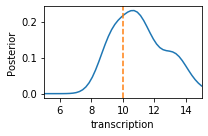

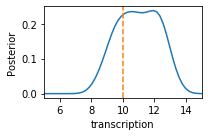

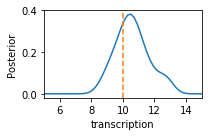

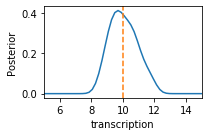

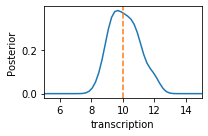

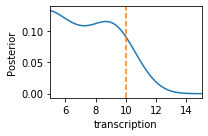

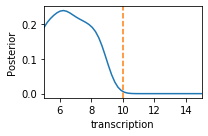

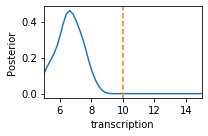

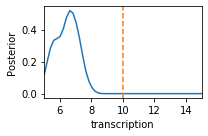

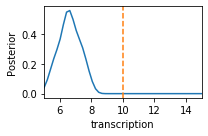

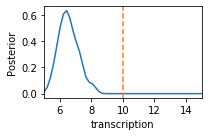

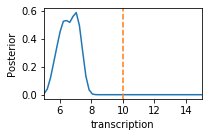

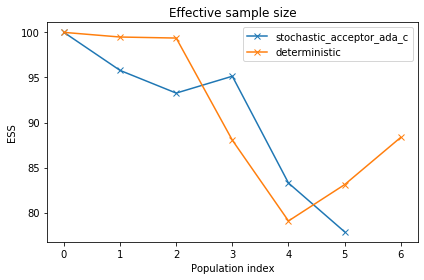

In [24]:
import pyabc
import os
import matplotlib.pyplot as plt
from study_abc_noise.model import MRNATranscriptionModelVars as ModelVars


mv = ModelVars()


db_files = [f for f in os.listdir('.') if os.path.isfile(f) and "db_" in f]
print(f"Using db files {db_files}")

histories = []
labels = []
for db_file in db_files:
    id_ = db_file.split('__')[1]
    h = pyabc.History("sqlite:///" + db_file)
    h.id = 1
    histories.append(h)
    labels.append(id_)


gt_par = h.get_population(t=-1).get_list()[0].parameter


pyabc.visualization.plot_sample_numbers(histories, labels)
plt.savefig("samples.png")
pyabc.visualization.plot_epsilons(histories, labels, scale="log10")
plt.savefig("epsilons.png")
for h, label in zip(histories, labels):
    for t in range(h.max_t + 1):
        df, w = h.get_distribution(t=t)
        pyabc.visualization.plot_kde_1d(df, w, x='transcription', xmin=5, xmax=15, refval=gt_par)
        plt.gcf().set_size_inches((3,2))
        plt.tight_layout()
        plt.savefig(f"kde_{label}_{t}.svg", format="svg")
pyabc.visualization.plot_effective_sample_sizes(histories, labels, rotation=45)
plt.savefig("ess.png")